# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

Загрузим каждый регион в отдельный датафрейм.

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
print(geo_data_0.info())
print()

geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
print(geo_data_1.info())
print()

geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
print(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memor

Проверим данные

In [3]:
def check_columns(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [4]:
check_columns(geo_data_0)
print()
check_columns(geo_data_1)
print()
check_columns(geo_data_2)

Уникальные значения столбца id
['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
Уникальные значения столбца f0
[0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]
Уникальные значения столбца f1
[-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]
Уникальные значения столбца f2
[ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]
Уникальные значения столбца product
[105.28006184  73.03775027  85.26564713 ...  64.37544259  74.04076435
 149.63324561]

Уникальные значения столбца id
['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
Уникальные значения столбца f0
[-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]
Уникальные значения столбца f1
[-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]
Уникальные значения столбца f2
[-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]
Уникальные значения столб

Проблем в данный не видим. Удалим из каждого датафрейма столбец id.,так как он не несет смысловой нагрузки.

In [5]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

In [6]:
def oil_hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

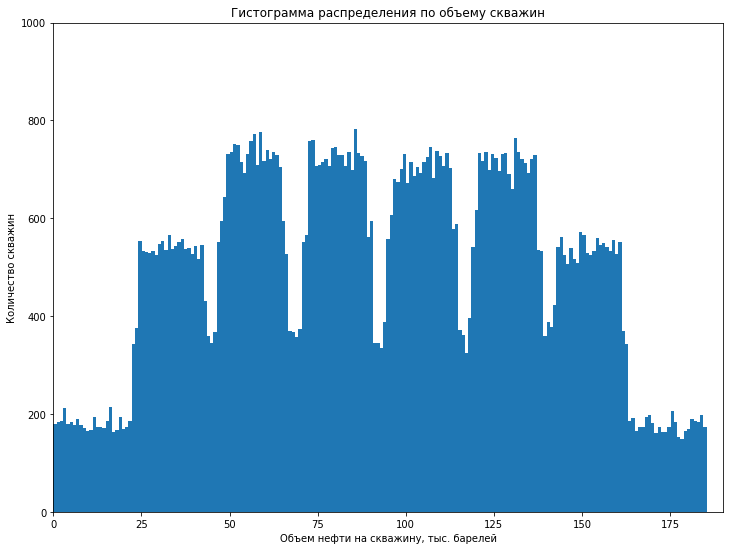

In [7]:
oil_hist(geo_data_0['product'], 200, 190, 1000)

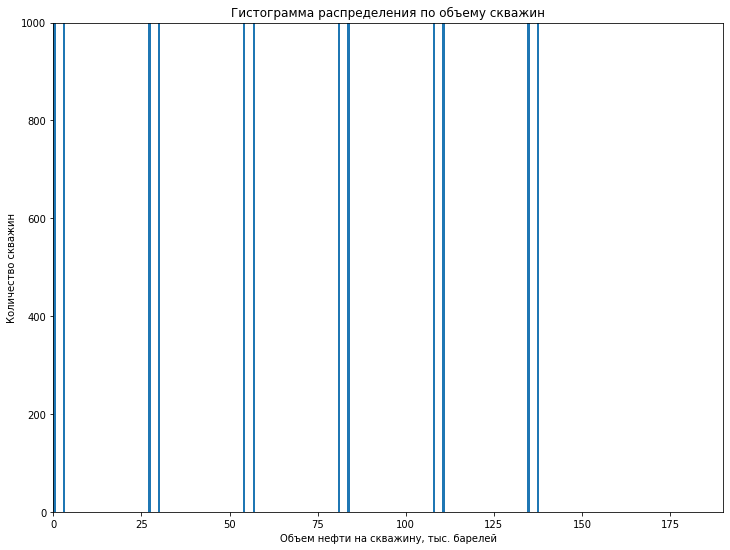

In [8]:
oil_hist(geo_data_1['product'],  200, 190, 1000)

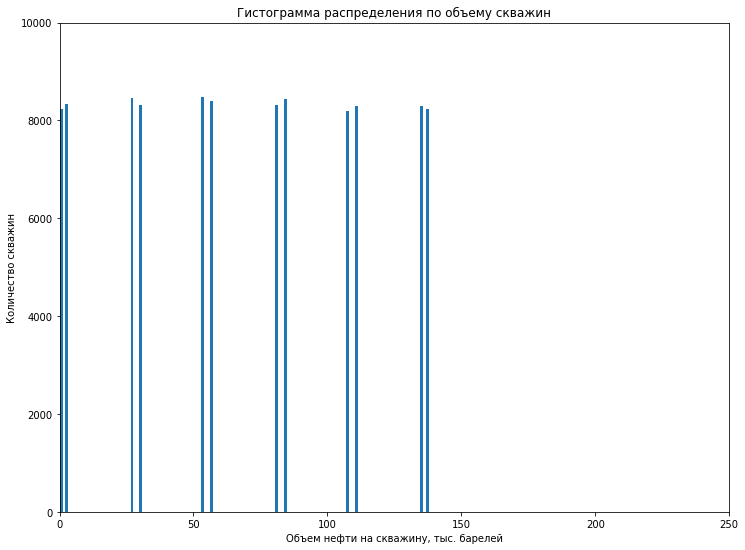

In [9]:
oil_hist(geo_data_1['product'],  125, 250, 10000)

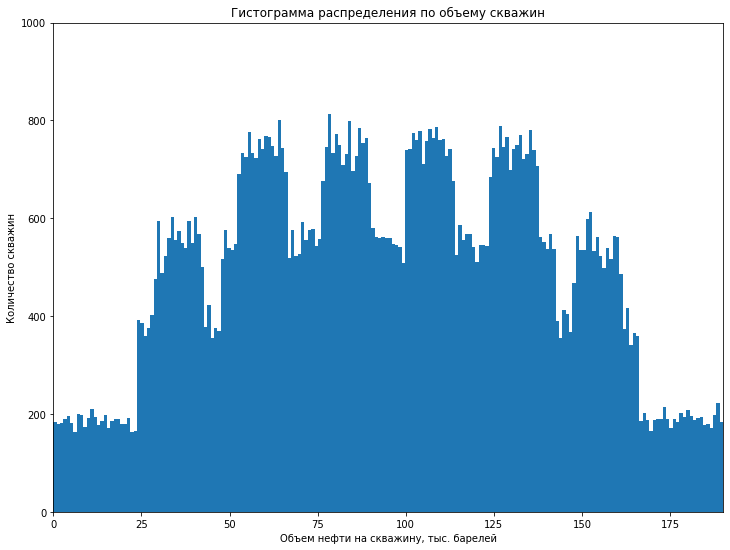

In [10]:
oil_hist(geo_data_2['product'], 200, 190, 1000)

In [11]:
def check_zeros(df, target_name):
    zeros = df[df[target_name] == 0][target_name].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Процент нулевых значений -', percent)

In [12]:
check_zeros(geo_data_0, 'product')
check_zeros(geo_data_1, 'product')
check_zeros(geo_data_2, 'product')

Количество нулевых значений - 1
Процент нулевых значений - 1e-05
Количество нулевых значений - 8235
Процент нулевых значений - 0.08235
Количество нулевых значений - 1
Процент нулевых значений - 1e-05


**Вывод по шагу 1.**

Данные готовы к обучению.

Во втором месторождении 8,2% месторождений не имело значения в столбце product.

По гистограммам можно понять, что у первого и третьего региона наспределение скважин близкое к нормальному. Во втором регионе данные имеют странное распределение. Данные или искуственные или в них ошибка.

## Обучение и проверка модели

Проверим качество модели линейной регрессии с текущим значением признаков и с масштабируемыми. Проверим эту гипотезу на geo_data_0.

Выполняем разбивку неподготовленного датафрейма.

In [13]:
def test_split(df, target):
    features = df.drop([target] , axis=1)
    target = df[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    return features_train, features_valid, target_train, target_valid

In [14]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split(geo_data_0, 'product')

features_train_0.head()

,f0,f1,f2
78638,0.602333,-0.445623,3.165303
67323,-0.984306,0.046746,0.400594
25303,0.085069,0.050226,-0.374703
80751,0.174317,0.011649,4.180446
28950,0.372650,1.031981,2.904160


In [15]:
def test_split_scaled(df, numeric, target):
    geo_data_s = df.copy()

    features_s = geo_data_s.drop([target] , axis=1)
    target_s = geo_data_s[target]

    features_train_s, features_valid_s, target_train_s, target_valid_s = train_test_split(
        features_s, target_s, test_size=0.25, random_state=5062020)

    scaler = StandardScaler()
    scaler.fit(features_train_s[numeric])
    features_train_s[numeric] = scaler.transform(features_train_s[numeric])
    features_valid_s[numeric] = scaler.transform(features_valid_s[numeric])

    return features_train_s, features_valid_s, target_train_s, target_valid_s

features - данные без масштаба
features_s - данные с масштабом

In [16]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 37.401957199217094


Проверим каково RMSE на маштабированных данных.

In [17]:
features_train_0s, features_valid_0s, target_train_0s, target_valid_0s = test_split_scaled(
                                                                        geo_data_0, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_0s, target_train_0s)
predicted_target_0s = model.predict(features_valid_0s)
print('RMSE -', mean_squared_error(target_valid_0s, predicted_target_0s)**0.5)

RMSE - 37.401957199217094


In [18]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split(geo_data_1, 'product')
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE -', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

features_train_1s, features_valid_1s, target_train_1s, target_valid_1s = test_split_scaled(
                                                                        geo_data_1, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_1s, target_train_1s)
predicted_target_1s = model.predict(features_valid_1s)
print('RMSE -', mean_squared_error(target_valid_1s, predicted_target_1s)**0.5)

RMSE - 0.8874258342572853
RMSE - 0.887425834257285


In [19]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split(geo_data_2, 'product')
model.fit(features_train_2, target_train_2)
predicted_target_2 = model.predict(features_valid_2)
print('RMSE -', mean_squared_error(target_valid_2, predicted_target_2)**0.5)

features_train_2s, features_valid_2s, target_train_2s, target_valid_2s = test_split_scaled(
                                                                        geo_data_2, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_2s, target_train_2s)
predicted_target_2s = model.predict(features_valid_2s)
print('RMSE -', mean_squared_error(target_valid_2s, predicted_target_2s)**0.5)

RMSE - 40.18553497171235
RMSE - 40.18553497171235


Масштабирование данных не требуется. Проверим показатель RMSE при других гиперпараметрах модели.

In [20]:
model = LinearRegression(normalize=True)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 37.401957199217094


In [21]:
model = LinearRegression(fit_intercept=False)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 60.749819777751355


Изменение стандартных значений гиперпараметров не улучшило модель. Произведем вывод предсказанного запаса с реальным и выведем RMSE.

In [22]:
model = LinearRegression()

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [23]:
geo_data_0_predicted, geo_data_0_rmse, geo_data_0_predicted_mean, geo_data_0_predicted_sum = oil_predict(geo_data_0, 'product')
print(geo_data_0_predicted.head())
print('RMSE -', geo_data_0_rmse)
print('Средний запас запасанного сырья -', geo_data_0_predicted_mean)

       real_product  predicted_product
87351    145.407098         110.644337
52805    131.589165          76.793446
6583     101.596316         103.711077
34986      8.123407          53.135348
8253     169.834019         151.656408
RMSE - 37.401957199217094
Средний запас запасанного сырья - 92.52620585803335


In [24]:
geo_data_1_predicted, geo_data_1_rmse, geo_data_1_predicted_mean, geo_data_1_predicted_sum = oil_predict(geo_data_1, 'product')
print(geo_data_1_predicted.head())
print('RMSE -', geo_data_1_rmse)
print('Средний запас запасанного сырья -', geo_data_1_predicted_mean)

       real_product  predicted_product
87351     53.906522          54.336477
52805      3.179103           3.756436
6583      30.132364          31.266991
34986     26.953261          26.692436
8253      30.132364          31.128898
RMSE - 0.8874258342572853
Средний запас запасанного сырья - 68.27820207556354


In [25]:
geo_data_2_predicted, geo_data_2_rmse, geo_data_2_predicted_mean, geo_data_2_predicted_sum = oil_predict(geo_data_2, 'product')
print(geo_data_2_predicted.head())
print('RMSE -', geo_data_2_rmse)
print('Средний запас запасанного сырья -', geo_data_2_predicted_mean)

       real_product  predicted_product
87351    140.971569          62.929196
52805    125.190694          98.323840
6583      94.544056          79.920918
34986    107.208380         104.706020
8253     173.924418         114.066050
RMSE - 40.18553497171235
Средний запас запасанного сырья - 94.94294307153748


In [26]:
print('Суммарный предсказанный запас в позиции 0 -', geo_data_0_predicted_sum)
print('Суммарный реальный запас в позиции 0 -', geo_data_0_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 1 -', geo_data_1_predicted_sum)
print('Суммарный реальный запас в позиции 1 -', geo_data_1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 2 -', geo_data_2_predicted_sum)
print('Суммарный реальный запас в позиции 2 -', geo_data_2_predicted['real_product'].sum())

Суммарный предсказанный запас в позиции 0 - 2313155.146450834
Суммарный реальный запас в позиции 0 - 2313395.805667925

Суммарный предсказанный запас в позиции 1 - 1706955.0518890887
Суммарный реальный запас в позиции 1 - 1706710.3444370048

Суммарный предсказанный запас в позиции 2 - 2373573.576788437
Суммарный реальный запас в позиции 2 - 2378821.7815969232


**Вывод по шагу 2**

Данные предсказаний о количестве нефти по сумме примерно совпадают по сумме с предсказанными значениями. Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.88), далее в первом и третьем соотвественно.

Возможно утеряные данные из второго региона сказались на модели и она достаточно сильно переобучилась.

Но из-за утери данных и малого запаса в среднем на меторождение не имеет смысла рассматривать второе месторождение как прибыльное.

Изучим все регионы на риски и прибыль, но в конечном итоге будем выбирать между 1 и 3 регионом.

## Подготовка к расчёту прибыли

Создадим переменные об экономической информации.

In [44]:
budget = 10000000 #Мы расчитываем прибыль в тысячах рублей за тысячу барелей, поэтому 1 милиард сохранен таким образом
chosen_points = 500
best_points = 200
price_per_barrel = 450

Расчитаем безубыточную разработку сырья на 200 месторождениях. И найдем среднее количество продукта в месторождениях необходимое для этого.

In [45]:
average_profit_per_point = budget / best_points
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / price_per_barrel
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. барелей')

average_barrels = budget / price_per_barrel
print('Средний объем нефти на регион -',average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку - 50000.0 тыс.руб.
Средний объем нефти на точку - 111.11111111111111 тыс. барелей
Средний объем нефти на регион - 22222.222222222223 тыс. барелей


In [29]:
print('Средний запас фактичекой нефти на скважину в регионе 1: ', geo_data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2: ', geo_data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3: ', geo_data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1:  92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2:  68.82500000000002
Средний запас фактичекой нефти на скважину в регионе 3:  95.00000000000004


Создадим функцию для расчета прибыли на 500 точек.

In [30]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

Выведем распределение предсказанных значений.

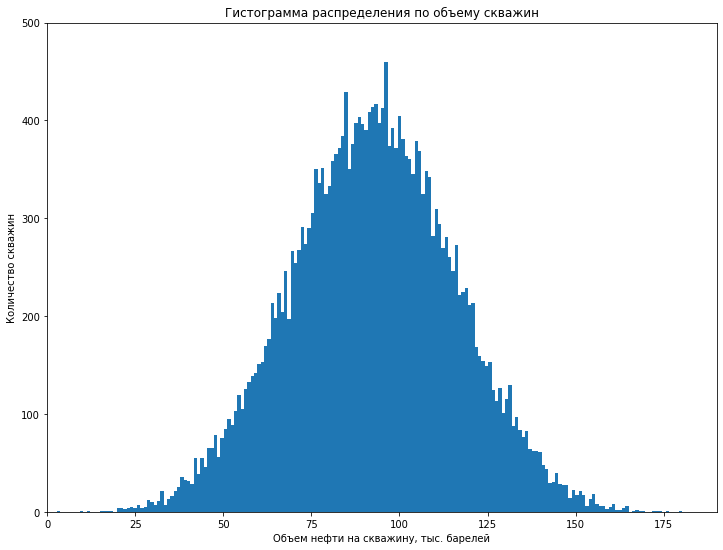

In [31]:
oil_hist(geo_data_0_predicted['predicted_product'], 200, 190, 500)

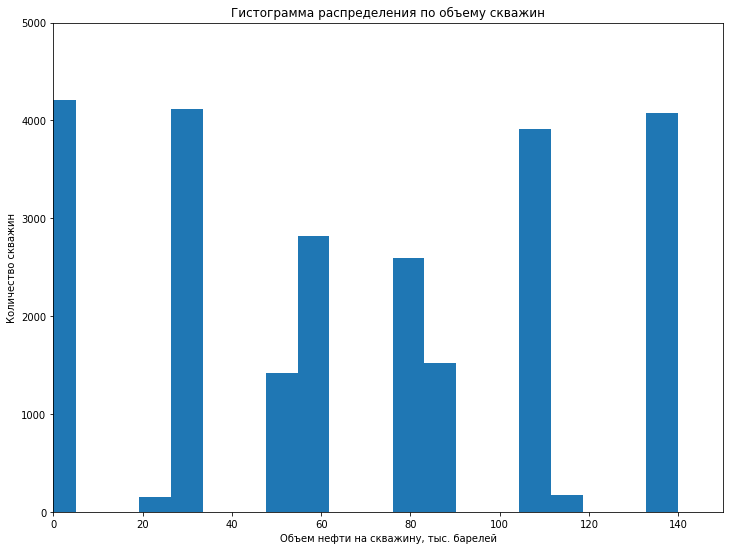

In [32]:
oil_hist(geo_data_1_predicted['predicted_product'], 20, 150, 5000)

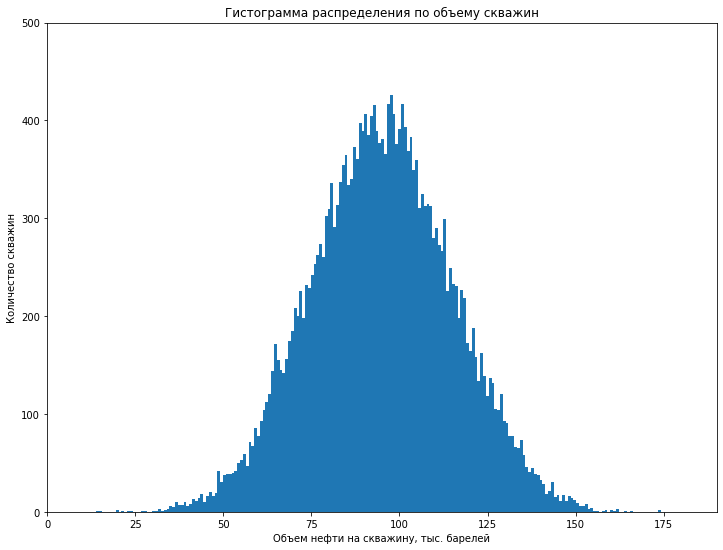

In [33]:
oil_hist(geo_data_2_predicted['predicted_product'], 200, 190, 500)

**Вывод по шагу 3**

Была подготовлена средняя оценка прибили за скважину и средний объем на скважину. И создана функция по расчету прибыли.

Изучены средние фактические запасы. Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего.

Во вторых данных возможно есть определенный смысл - значений больше 111 достаточно много и при определенной доли везения можно выбрать только лучшие в этой выборке, хотя и среднее значение 68.8.

## Расчёт прибыли и рисков 

In [34]:
state = np.random.RandomState(777)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [35]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(geo_data_0_predicted['real_product'], 
                                                     geo_data_0_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

print('-------------------')

average_1, lower_1, upper_1, risk_1 = bootstrap_1000(geo_data_1_predicted['real_product'], 
                                                     geo_data_1_predicted['predicted_product'])
print('Данные по второму региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

print('-------------------')

average_2, lower_2, upper_2, risk_2 = bootstrap_1000(geo_data_2_predicted['real_product'], 
                                                     geo_data_2_predicted['predicted_product'])
print('Данные по третьему региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по первому региону.
Средняя прибыль по региону = 444273.07 тыс.руб.
95% доверительный интервал от -62354.93 до 927999.53 тыс.руб.
Процент риска 4.00%
-------------------
Данные по второму региону.
Средняя прибыль по региону = 420806.79 тыс.руб.
95% доверительный интервал от 32431.90 до 827250.91 тыс.руб.
Процент риска 1.50%
-------------------
Данные по третьему региону.
Средняя прибыль по региону = 392909.18 тыс.руб.
95% доверительный интервал от -97875.41 до 880862.49 тыс.руб.
Процент риска 7.20%


**Вывод по шагу 4**

Данные были обработаны и рассчитаны прибыль, интервал и риски.

Мы отсеиваем первый и третий регион, так как риски остаточно велики. Остается один единственный - второй, чей риск ниже требуемого. Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.

**Итоговый вывод**

При выполнении следующего проекта было выполнено:

Изучины данные. Проведена подготовка данных к моделированию.
Обучена модель для каждого региона geo_data_0, geo_data_1 и geo_data_2.
Составлена функция расчета прибыли в регионе.
Посчитана прибыль и риски за каждый регион и обоснован выбор региона.
Второй регион получился одним из лучших по показателям предсказывания, **хотя данные не выглядят нормально распределенными и вцелом подозрительно**.